In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../lib")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
from temporal_encoder_common import Filters
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases

In [24]:
n_neurons = 500
n_temporal_dimensions = 7
n_dimensions = 2

def mk_encs(n, d, rng=np.random):
    encs = rng.normal(0, 1, (n, d))
    encs /= np.linalg.norm(encs, axis=1)[:, None]
    return encs

gains, biases, _ = nonneg_common.mk_ensemble(n_neurons, d=1)
G = lif_utils.lif_rate
TEs = mk_encs(n_neurons, n_temporal_dimensions)
Es = mk_encs(n_neurons, n_dimensions)

A, B = bases.mk_ldn_lti(n_temporal_dimensions)

T, dt = 10.0, 1e-3
ts = np.arange(0, T, dt)
Ms = temporal_encoder_common.cached_lti_impulse_response(A, B, ts)

flts_in = [(100e-3,),]
flts_rec = [(100e-3,),]

In [25]:
np.random.seed(58381)
W_in, W_rec, errs = temporal_encoder_common.solve_for_recurrent_population_weights_with_spatial_encoder(
    G, gains, biases, None, None, TEs, Es,
    [Filters.lowpass(*flt_in) for flt_in in flts_in],
    [Filters.lowpass(*flt_rec) for flt_rec in flts_rec],
    Ms=Ms,
    N_smpls=100,
    xs_sigma=3.0,
    biased=False,)

100%|██████████| 500/500 [00:13<00:00, 36.42it/s]


In [92]:
np.random.seed(498184)

def LP(*args):
    return nengo.LinearFilter(*Filters.lowpass_laplace(*args), analog=True)

with nengo.Network() as model:
    nd_in = nengo.Node(size_in=n_dimensions)
    for i in range(n_dimensions):
        nd_noise = nengo.Node(nengo.processes.WhiteSignal(period=100.0, high=1.0, y0=0.0, rms=0.5))
        nengo.Connection(nd_noise, nd_in[i], synapse=None)
    
    ens_x = nengo.Ensemble(
        n_neurons=n_neurons,
        #dimensions=n_temporal_dimensions,
        dimensions=1,
        bias=biases,
        gain=gains,
        #encoders=TEs,
        encoders=np.ones((n_neurons, 1))
    )

    for i_flt, flt_in in enumerate(flts_in):
        nengo.Connection(
            nd_in, ens_x.neurons,
            transform=W_in[:, :, i_flt],
            synapse=LP(*flt_in))

    for i_flt, flt_rec in enumerate(flts_rec):
        nengo.Connection(
            ens_x.neurons, ens_x.neurons,
            transform=W_rec[:, :, i_flt],
            synapse=LP(*flt_rec))

    p_in = nengo.Probe(nd_in, synapse=None)
    p_out = nengo.Probe(ens_x, synapse=100e-3)
    p_out_neurons = nengo.Probe(ens_x.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [97]:
xs1_flt = np.concatenate((np.zeros(500), nengo.Lowpass(100e-3).filtfilt(xs[:, 0])))[:-500]
xs2_flt = np.concatenate((np.zeros(500), nengo.Lowpass(100e-3).filtfilt(xs[:, 1])))[:-500]
As_flt = nengo.Lowpass(100e-3).filtfilt(As)

In [106]:
def execute_network(xs,
                    W_in,
                    W_rec,
                    gains,
                    biases,
                    T=10.0,
                    dt=1e-3,
                    tau=100e-3):
    N = int(T / dt + 1e-9)
    n_dims = n_dimensions
    n_neurons = len(gains)

    with nengo.Network() as model:
        nd_in = nengo.Node(size_in=n_dims)
        for i in range(n_dims):
            def mk_sig(i=i):
                return lambda t: xs[int(t / dt) % N, i]
            #nd_noise = nengo.Node(mk_sig())
            nd_noise = nengo.Node(nengo.processes.WhiteSignal(period=100.0, high=1.0, y0=0.0, rms=0.5))
            nengo.Connection(nd_noise, nd_in[i], synapse=None)

        ens_x = nengo.Ensemble(n_neurons=n_neurons,
                               dimensions=1,
                               bias=biases,
                               gain=gains,
                               encoders=np.ones((n_neurons, 1)))

        nengo.Connection(nd_in,
                         ens_x.neurons,
                         transform=W_in[:, :, 0],
                         synapse=tau)

        nengo.Connection(ens_x.neurons,
                         ens_x.neurons,
                         transform=W_rec[:, :, 0],
                         synapse=tau)

        p_in = nengo.Probe(nd_in, synapse=None)
        p_out = nengo.Probe(ens_x.neurons, synapse=None)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T)

    return sim.data[p_in], sim.data[p_out]

xs_test, As_test = execute_network(None, W_in, W_rec, gains, biases)
xs_train, As_train = execute_network(None, W_in, W_rec, gains, biases)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [107]:
xs_train_flt = nengo.Lowpass(100e-3).filtfilt(xs_train)
As_train_flt = nengo.Lowpass(100e-3).filtfilt(As_train)

xs_test_flt = nengo.Lowpass(100e-3).filtfilt(xs_test)
As_test_flt = nengo.Lowpass(100e-3).filtfilt(As_test)

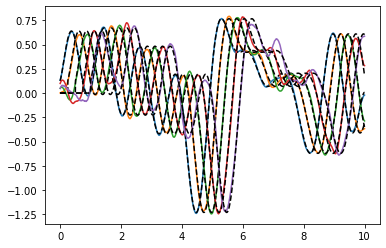

In [110]:
def shift(xs, t, dt=1e-3):
    N = xs.shape[0]
    N_shift = int(t / dt)
    return np.concatenate((np.zeros(N_shift), xs))[:N]

fig, ax = plt.subplots()

for theta in np.linspace(0, 1.0, 5):
    xs_train_flt_shift = shift(xs_train_flt[:, 0], theta)
    xs_test_flt_shift = shift(xs_test_flt[:, 0], theta)
    d1 = np.linalg.lstsq(As_train_flt, xs_train_flt_shift, rcond=1e-2)[0]

    ax.plot(ts, As_train_flt @ d1)
    ax.plot(ts, xs_train_flt_shift, 'k--')

In [109]:
xs1_flt = np.concatenate((np.zeros(500), nengo.Lowpass(100e-3).filtfilt(sim.data[p_in][:, 0])))[:-500]
xs2_flt = np.concatenate((np.zeros(500), nengo.Lowpass(100e-3).filtfilt(sim.data[p_in][:, 1])))[:-500]
As_flt = nengo.Lowpass(100e-3).filtfilt(sim.data[p_out_neurons])

In [71]:
d1 = np.linalg.lstsq(As_flt, xs1_flt, rcond=1e-2)[0]
d2 = np.linalg.lstsq(As_flt, xs2_flt, rcond=1e-2)[0]

In [72]:
#dprod = np.linalg.lstsq(As_flt, 2.0 * xs1_flt * xs2_flt, rcond=1e-2)[0]

(0.0, 10000.0)

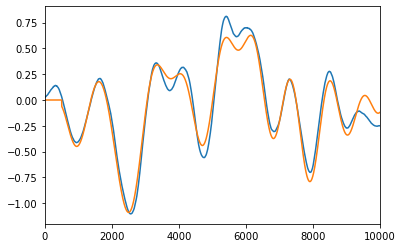

In [98]:
fig, ax = plt.subplots()
ax.plot(As_flt @ d1)
ax.plot(xs1_flt)
ax.set_xlim(0, 10000)

(0.0, 10000.0)

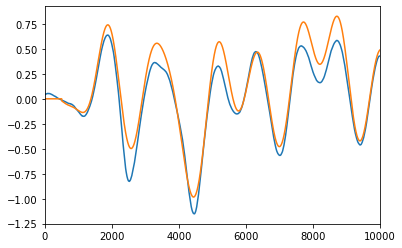

In [99]:
fig, ax = plt.subplots()
ax.plot(As_flt @ d2)
ax.plot(xs2_flt)
ax.set_xlim(0, 10000)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 100)

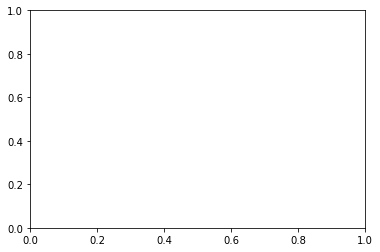

In [338]:
fig, ax = plt.subplots()
ax.plot(As_flt @ dprod)
ax.plot(2.0 * xs1_flt * xs2_flt)
ax.set_xlim(0, 10000)

(0.0, 20.0)

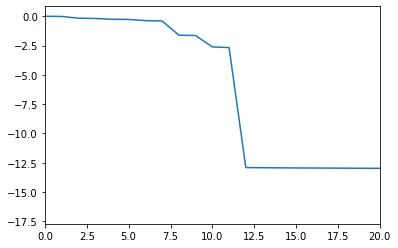

In [252]:
fig, ax = plt.subplots()
U, S, V = np.linalg.svd(W_rec[:, :, 0])
ax.plot(np.log10(S / np.max(S)))
ax.set_xlim(0, 20)

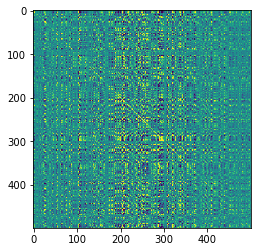

In [207]:
fig, ax = plt.subplots()
ax.imshow(W_rec[:, :, 0], vmin=-1e-4, vmax=1e-4)